# Implementing XResNets from Scratch

#### Last Time
[Most recently](http://nbviewer.jupyter.org/github/jamesdellinger/fastai_deep_learning_course_part2_v3/blob/master/10c_fp16_my_reimplementation.ipynb?flush_cache=true), we successfully implemented a mixed-precision training loop that employs dynamic loss scaling. 

#### XResNets
Here we demonstrate an extremely *concise* and readable way of implementing XResNets. In contrast to traditional ResNet implementations, that go on and on for several (possibly hundred) lines of code, our code is shockingly condensed. At the same time it is far more flexible than traditional implementations, allowing us to instantiate any depth of XResNet (18, 34, 50, 101, or 152) in just a single line of code!

Introduced in the [one of my favorite papers](https://arxiv.org/abs/1812.01187), by He, Zhang, et. al., the XResNet architecture adds tweaks to the stem and residual blocks of traditional ResNet models. These improvements led to a 1% improvement in ImageNet Top-1 accuracy score (XResNet50 vs. ResNet50).

## Setup
As always, we're working with the [Imagenette](https://github.com/fastai/imagenette) dataset:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#export
from exports.nb_10c import *

In [3]:
path = datasets.untar_data(imagenette_url)
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs=64

data = (ImageList.from_files(path, tfms=tfms)
        .to_split(partial(grandparent_splitter, valid_name='val'))
        .to_label(parent_labeler, y_processor=CategoryProcessor())
        .to_databunch(bs, channels_in=3, channels_out=10, num_workers=4))

## XResNet

In [4]:
#export
def noop(x): return x

class Flatten(nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)
    
def conv(n_in, n_out, ks=3, stride=1, bias=False):
    return nn.Conv2d(n_in, n_out, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

In [15]:
#export
act_fn = nn.ReLU(inplace=True)

def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
        
def conv_layer(n_in, n_out, ks=3, stride=1, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(n_out)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(n_in, n_out, ks, stride=stride), bn]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

In [23]:
#export
class ResBlock(nn.Module):
    def __init__(self, expansion, n_in, n_hidden, stride=1):
        super().__init__()
        n_out, n_in = n_hidden*expansion, n_in*expansion
        layers = [conv_layer(n_in, n_hidden, 1)]
        layers += [
            conv_layer(n_hidden, n_out, 3, stride=stride, zero_bn=True, act=False)
        ] if expansion == 1 else [
            conv_layer(n_hidden, n_hidden, 3, stride=stride),
            conv_layer(n_hidden, n_out, 1, zero_bn=True, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        self.idconv = noop if n_in == n_out else conv_layer(n_in, n_out, 1, act=False)
        self.pool = noop if stride == 1 else nn.AvgPool2d(2, ceil_mode=True)
        
    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

In [64]:
#export
class XResNet(nn.Sequential):
    @classmethod
    def create(cls, expansion, layers, channels_in=3, channels_out=1000):
        n_outs = [channels_in, (channels_in+1)*8, 64, 64]
        stem = [conv_layer(n_outs[i], n_outs[i+1], stride=2 if i==0 else 1)
               for i in range(3)]
        
        n_outs = [64//expansion, 64, 128, 256, 512]
        res_layers = [cls._make_layer(expansion, n_outs[i], n_outs[i+1],
                                      n_blocks=1, stride=1 if i==0 else 2)
                     for i, l in enumerate(layers)]
        res = cls(*stem,
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                  *res_layers,
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(),
                  nn.Linear(n_outs[-1]*expansion, channels_out)
        )
        init_cnn(res)
        return res
    
    @staticmethod
    def _make_layer(expansion, n_in, n_out, n_blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, n_in if i==0 else n_out, n_out, stride if i==0 else 1)
             for i in range(n_blocks)])

In [58]:
#export
def XResNet18 (**kwargs): return XResNet.create(1, [2, 2,  2, 2], **kwargs)
def XResNet34 (**kwargs): return XResNet.create(1, [3, 4,  6, 3], **kwargs)
def XResNet50 (**kwargs): return XResNet.create(4, [3, 4,  6, 3], **kwargs)
def XResNet101(**kwargs): return XResNet.create(4, [3, 4, 23, 3], **kwargs)
def XResNet152(**kwargs): return XResNet.create(4, [3, 8, 36, 3], **kwargs)

## Training an XResNet18 model

In [31]:
callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  ProgressBarCallback,
                  Recorder,
                  LR_Find,
                  partial(BatchTransformXCallback, norm_imagenette),
                  MixUp]

loss_func = LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [32]:
arch = partial(XResNet18, c_out=10)

Our old version of `model_summary` worked with the `Runner` class, which we've since replaced with `Learner`. We'll reimplement `model_summary` here to keep it compatible with our updated training loop:

In [34]:
#export
def get_batch(data_loader, learn):
    learn.xb, learn.yb = next(iter(data_loader))
    learn.do_begin_fit(0)
    learn('begin_batch')
    learn('after_fit')
    return learn.xb, learn.yb

def model_summary(model, data, find_all=False, print_model=False):
    xb, yb = get_batch(data.valid_dl, learn)
    modules = find_modules(model, is_lin_layer) if find_all else model.children()
    f = lambda hook, model, input, output: print(f"====\n{model}\n" if print_model else "", output.shape)
    with ForwardHooks(modules, f) as hooks: learn.model(xb)

In [35]:
learn = Learner(arch(), data, loss_func, lr=1, callback_funcs=callback_funcs, opt_func=opt_func)

In [36]:
learn.model = learn.model.cuda()
model_summary(learn.model, data, print_model=False)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


 torch.Size([128, 32, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 64, 64])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 64, 32, 32])
 torch.Size([128, 128, 16, 16])
 torch.Size([128, 256, 8, 8])
 torch.Size([128, 512, 4, 4])
 torch.Size([128, 512, 1, 1])
 torch.Size([128, 512])
 torch.Size([128, 10])


In [37]:
learn.fit(2)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time


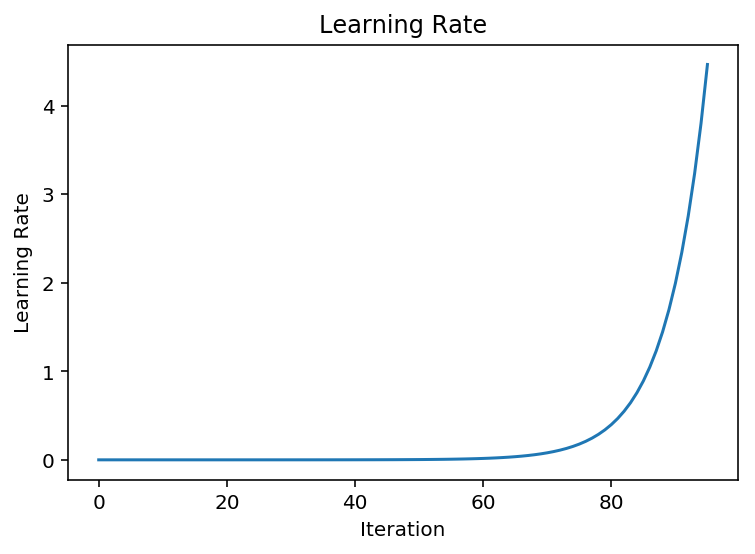

In [39]:
learn.recorder.plot_lr()

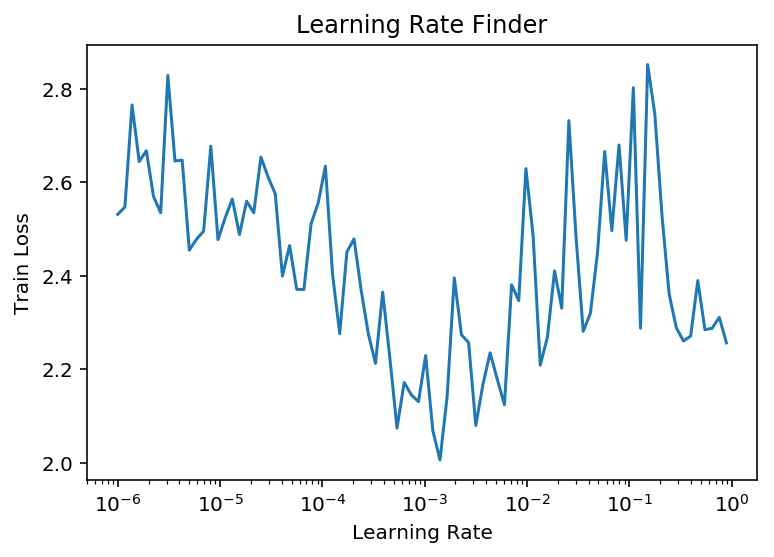

In [40]:
learn.recorder.plot(skip_last=10)

In [41]:
callback_funcs = [partial(AvgStatsCallback, accuracy),
                  CudaCallback,
                  ProgressBarCallback,
                  Recorder,
                  partial(BatchTransformXCallback, norm_imagenette),
                  MixUp]
learn = Learner(arch(), data, loss_func, lr=1e-3, callback_funcs=callback_funcs, opt_func=opt_func)

In [42]:
learn.fit(8)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.950578,0.432294,1.627545,0.540000,00:46
1,1.738268,0.571506,1.395509,0.648000,00:47
2,1.619803,0.646347,1.378325,0.632000,00:47
3,1.549181,0.690942,1.184395,0.748000,00:47
4,1.496616,0.719017,1.289732,0.682000,00:47
5,1.454728,0.750271,1.112759,0.766000,00:47
6,1.425953,0.771832,1.164534,0.750000,00:47
7,1.391753,0.795409,1.018245,0.828000,00:47


## Training an XResNet34 model
We'll use train our XResNet34 model with under a one-cycle cyclical learning rate regime. Here's a helper function to make it easier to specify the warm-up and annealing phases:

In [59]:
#export
def create_phases(phases):
    phases = listify(phases)
    return phases + [1 - sum(phases)]

In [60]:
print(create_phases(0.3))
print(create_phases([0.3, 0.2]))

[0.3, 0.7]
[0.3, 0.2, 0.5]


We'll also use discriminative learning rate and momentum schedules for three parameter groups:

In [61]:
lr = 1e-3
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))
schedules = [ParamScheduler('lr', sched_lr), ParamScheduler('mom', sched_mom)]

#### cnn_learner
While we're at it, we can create another convenience method to help us have an easier time setting up `Learner()` objects for CNN models:

In [65]:
#export
def cnn_learner(arch, data, loss_func, opt_func, channels_in=None, channels_out=None,
                lr=1e-3, cuda=True, batchnorm=None, progress_bar=True, mixup=0, 
                extra_callbacks=None, **kwargs):
    callback_funcs = [partial(AvgStatsCallback, accuracy), Recorder] + listify(extra_callbacks)
    if progress_bar: callback_funcs.append(ProgressBarCallback)
    if cuda: callback_funcs.append(CudaCallback)
    if batchnorm: callback_funcs.append(partial(BatchTransformXCallback, batchnorm))
    if mixup: callback_funcs.append(partial(MixUp, mixup))
    arch_args = {}
    if not channels_in : channels_in  = data.channels_in
    if not channels_out: channels_out = data.channels_out
    if channels_in:  arch_args['channels_in' ] = channels_in
    if channels_out: arch_args['channels_out'] = channels_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, callback_funcs=callback_funcs, **kwargs)
    

In [67]:
learn = cnn_learner(XResNet34, data, loss_func, lr=lr, opt_func=opt_func, batchnorm=norm_imagenette, mixup=0.4)

In [68]:
learn.fit(8, schedules)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,2.055462,0.351714,1.716005,0.496000,00:47
1,1.866230,0.492555,1.601209,0.546000,00:47
2,1.756930,0.558011,1.458063,0.600000,00:47
3,1.674444,0.610361,1.309200,0.684000,00:47
4,1.597408,0.662168,1.204454,0.742000,00:47
5,1.507829,0.718396,1.115946,0.764000,00:47
6,1.441304,0.760199,1.034460,0.810000,00:47
7,1.387004,0.796727,1.005181,0.822000,00:47


Not bad -- we got to greater than 80% validation accuracy after only 8 epochs. What's more, we can attempt to use any flavor of XResNet we might desire (18, 34, 50, 101, or 152) by specifying this in a single line of code. The flexibility of this implementation is quite impressive!

## Export

In [69]:
nb_auto_export()

<IPython.core.display.Javascript object>